In [1]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import linregress

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

'''Import script which contains functions'''
import analysis_functions
from analysis_functions import get_r2

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

/home/prubbens/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/prubbens/.local/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Import the dataframes: 

In [2]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
data_rel = pd.read_csv('data/Chloroplasts_removed/nochloro_relative_otu.tsv', sep=' ', index_col=None, header=0)
target = pd.read_csv('data/Chloroplasts_removed/nochloro_HNA_LNA.tsv', sep=' ', index_col=0, header=0)
productivity = pd.read_csv('data/Chloroplasts_removed/productivity_data.tsv', sep=' ', index_col=0, header=0)

In [3]:
'''Set sample names as index and shuffle data'''
data_abs.set_index(target.samples,inplace=True)
data_rel.set_index(target.samples,inplace=True)
data_abs = data_abs.sample(frac=1, random_state=3)
data_rel = data_rel.sample(frac=1, random_state=3)
target = target.sample(frac=1, random_state=3)
productivity = productivity.sample(frac=1, random_state=3)

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna_rel.index)

**-- PREPROCESSING OF DATA --**

**1)**: filter out those OTUs which have very low abundances and so give rise to (almost) zero-columns. Therefore an OTU has to have a minimal relative abundance one, defined by the parameter $abun$. 

However, depending on the problem set-up, I use a **second constraint** which states that an OTU must have a relative abundance > $abun$ in one of the **productivity** samples. In this way we're going to bias the OTU-selection towards the ones which are considerably present in the productivity samples. 

In [4]:
'''Filtering based on productivity samples, not needed for first part of analysis'''
#retain only productivity samples 
#productivity = productivity.dropna(subset=['tot_bacprod'])
#remove high productivity samples (>90)
#productivity = productivity[productivity.tot_bacprod < 90]

#idx_prod = productivity.samples.values
#display(idx_prod)
#prod = pd.Series(productivity.tot_bacprod.values, index=idx_prod)
#prod_error = pd.Series(productivity.SD_tot_bacprod.values, index=idx_prod)
#prod_rel_error = prod_error/prod

'Filtering based on productivity samples, not needed for first part of analysis'

In [5]:
'''Parameter abun for initial filtering of OTUs'''
abun = 0.0075

In [6]:
from analysis_functions import preprocess_df
data_abs = preprocess_df(data_abs,abun,True)
otus = list(data_abs.columns)

print('Number of OTUs: ' + str(len(otus)))

Number of OTUs: 340


(Note that this number is the same whether we use absolute or relative abundances, as the filtering is based on a minimal _relative_ abundance.)

**Standardize data**: (needed for performing regression analyses)

In [7]:
scaler = StandardScaler() #Results in mean 0 and standard deviation of 1

data_abs = pd.DataFrame(scaler.fit_transform(data_abs[otus]),index=data_abs.index,columns=otus)
data_rel = pd.DataFrame(scaler.fit_transform(data_rel[otus]),index=data_rel.index,columns=otus)

Let's see how well these initially selected OTU's perform in a **4x5 cross-validated Lasso**: 

In [8]:
from analysis_functions import perform_nested_lasso_cv

alphas_abs, preds_abs = perform_nested_lasso_cv(data_abs[otus], hna)
alphas_rel, preds_rel = perform_nested_lasso_cv(data_rel[otus], hna)

r2_abs = get_r2(hna, preds_abs)
r2_rel = get_r2(hna, preds_rel)

print('R² based on absolute abundances: ' + str(r2_abs))
print('R² based on relative abundances: ' + str(r2_rel))

R² based on absolute abundances: 0.768364867229
R² based on relative abundances: 0.65603720658


The $R^2$ is already quite good. Let's check the $R^2$ if we would use the total cell counts to predict the HNA-counts: 

In [9]:
alphas_totcells, preds_totcells = perform_nested_lasso_cv(pd.DataFrame(target['Total.cells']), hna)
r2_totcells = get_r2(hna, preds_totcells)

print('R² based on total cell counts: ' + str(r2_totcells))

R² based on total cell counts: 0.712452030394


From this we already see that there already is added value in using absolute cell counts to predict the HNA-counts:
- $R^2_{HNA(abs)} = 0.768$
- $R^2_{HNA(Total.cells)} = 0.712$

**First goal: ** try to pinpoint those OTU's for which we are sure they are present in the '_HNA-cloud_'. 

To do so, we use the **_Randomized Lasso_**: this method makes use of two kinds of randomization in order to select variables (i.e., OTU's) with a certain _stability_: (1) it fits a Lasso to various bootstrap subsamples and (2) it perturbs the initial weighting of certain variables. 

This results in a $score \in [0,1]$ that is assigned to variables, with 0 denoting the case where a variable is never chosen by the Lasso, and 1 denoting the case where a variable always is chosen. In other words, the higher the score, the more important a variable can be considered to be. 

In [10]:
from analysis_functions import perform_randomizedLasso

otus_scores = pd.Series(perform_randomizedLasso(data_abs[otus], hna, alphas_abs.mean()), index=otus)
otus_scores.sort_values(ascending=False,inplace=True)
otus_scores.to_csv('HNAscores_abun0.0075.csv')

#Display top 10 OTUs:
display(otus_scores.head(10))

Otu000005    0.878
Otu000128    0.858
Otu000067    0.854
Otu000176    0.844
Otu000173    0.806
Otu000098    0.786
Otu000224    0.768
Otu000025    0.762
Otu000009    0.730
Otu000123    0.720
dtype: float64

We can use this score in order to fit a threshold $Thr$ in order to reduce the set of OTU's in function of the HNA counts: 

In [11]:
from analysis_functions import perform_nested_ridge_cv

thresholds = np.arange(0,1,0.01)
r2_scores = np.zeros(len(thresholds))
dummy=0

#Make copy of otu_scores to be able to rerun analysis: 
scores = otus_scores
for thr in thresholds: 
    scores = otus_scores[otus_scores.values > thr]
    features_new = scores.index
    if(len(features_new) > 0): 
        #alphas, preds = perform_nested_ridge_cv(data_abs[features_new],hna) #We could use this if we want a different evaluation model
        alphas, preds = perform_nested_lasso_cv(data_abs[features_new],hna)
        r2_scores[dummy] = get_r2(hna,preds)
    dummy+=1

/home/prubbens/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


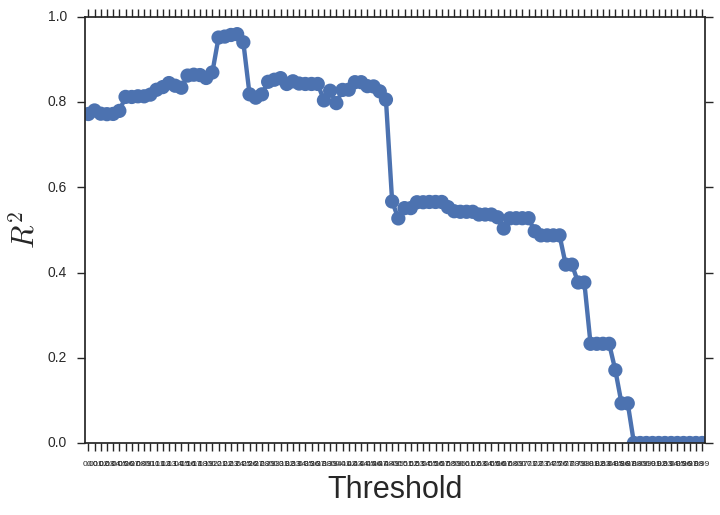

In [12]:
plt.figure()
plt.axis([0,1,0,1])
sns.pointplot(thresholds,r2_scores, scatter_kws={"s": 0.7})
plt.xlabel('Threshold', size=22)
plt.xticks(size=6)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.show()

Choose the value for which the $R^2$ is maximal: 

In [13]:
r2_max = r2_scores.max()
r2_max_idx = r2_scores.argmax()
thresh_max = thresholds[r2_max_idx]
optimal_scores = otus_scores[otus_scores.values>thresh_max]
selected_otus = optimal_scores.index

print('Number of selected OTUs: ' + str(len(selected_otus)))
print('R2 max = ' + str(r2_max))
print('Optimal threshold = ' + str(thresh_max))

optimal_scores.to_csv('HNAscores_abun0.0075_Thr0.24.csv')

Number of selected OTUs: 100
R2 max = 0.959174348345
Optimal threshold = 0.24


This leaves us with ~~340~~ **100 OTU's** resulting in an $R^2_{HNA(final)} = 0.959$. Depending on the desired amount of OTU's, $Thr$ can be varied accordingly. 

**-- WHAT IF WE ONLY CONSIDER THOSE OTU's WHICH ARE SIGNIFICANTLY PRESENT IN THE PRODUCTIVITY SAMPLES? --**

In [14]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/nochloro_absolute_otu.tsv', sep=' ', index_col=None, header=0)
data_rel = pd.read_csv('data/Chloroplasts_removed/nochloro_relative_otu.tsv', sep=' ', index_col=None, header=0)
target = pd.read_csv('data/Chloroplasts_removed/nochloro_HNA_LNA.tsv', sep=' ', index_col=0, header=0)
productivity = pd.read_csv('data/Chloroplasts_removed/productivity_data.tsv', sep=' ', index_col=0, header=0)

In [15]:
'''Set sample names as index and shuffle data'''
data_abs.set_index(target.samples,inplace=True)
data_rel.set_index(target.samples,inplace=True)
data_abs = data_abs.sample(frac=1, random_state=3)
data_rel = data_rel.sample(frac=1, random_state=3)
target = target.sample(frac=1, random_state=3)
productivity = productivity.sample(frac=1, random_state=3)

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna_rel.index)

~~**Preprocessing: ** First filter productivity outliers (productivity > 90).~~

In [16]:
#retain only productivity samples 
productivity = productivity.dropna(subset=['tot_bacprod'])
#remove high productivity samples (>90)
#productivity = productivity[productivity.tot_bacprod < 90]

idx_prod = productivity.samples.values
display(idx_prod)
prod = pd.Series(productivity.tot_bacprod.values, index=idx_prod)
#prod_error = pd.Series(productivity.SD_tot_bacprod.values, index=idx_prod)
#prod_rel_error = prod_error/prod

array(['MINE1-715', 'MDPE1-714', 'MBRE1-914', 'MOTE2-915', 'MBRE1-715',
       'MDPE1-914', 'MBRE1-714', 'MUSOUTE1-epi-outlet-514', 'MOTE1-714',
       'MOTE1-715', 'MOTE1-914', 'MBRE2-915', 'MINE1-714', 'MINE1-914',
       'MDPE2-515', 'MBRE2-515', 'MDPE1-715', 'MUSINLE1-epi-inlet-514',
       'MOTE2-515', 'MDPE2-915', 'MUSDEPE1-epi-deep-514', 'MINE2-515',
       'MINE2-915'], dtype=object)

In [17]:
abun = 0.0075 #Reduce the initial filtering a little bit

In [18]:
from analysis_functions import preprocess_df
data_abs_prod = data_abs.loc[idx_prod,:] 
data_abs_prod = preprocess_df(data_abs_prod,abun,True)
otus_prod = list(data_abs_prod.columns)

print('Number of OTUs: ' + str(len(otus_prod)))

Number of OTUs: 97


In [19]:
''' Standardize data '''
data_abs_prod = pd.DataFrame(scaler.fit_transform(data_abs[otus_prod]),index=data_abs.index,columns=otus_prod)

In [20]:
alphas_abs_prod, preds_abs_prod = perform_nested_lasso_cv(data_abs_prod[otus_prod], hna)
r2_abs_prod = get_r2(preds_abs_prod,hna)
print('R² with productivity filtering:' + str(r2_abs_prod))

R² with productivity filtering:0.841626586502


In [21]:
otus_scores_prod = pd.Series(perform_randomizedLasso(data_abs_prod[otus_prod], hna, alphas_abs_prod.mean()), index=otus_prod)
otus_scores_prod.sort_values(ascending=False,inplace=True)
otus_scores_prod.to_csv('HNAscores_prod_abun0.0075.csv')
display(otus_scores_prod.head(10))

Otu000123    0.998
Otu000027    0.996
Otu000043    0.986
Otu000057    0.976
Otu000176    0.970
Otu000005    0.966
Otu000048    0.962
Otu000040    0.956
Otu000058    0.952
Otu000067    0.940
dtype: float64

In [22]:
thresholds = np.arange(0,1,0.01)
r2_scores = np.zeros(len(thresholds))
dummy=0

#Make copy of otu_scores to be able to rerun analysis: 
scores = otus_scores_prod
for thr in thresholds: 
    scores = otus_scores_prod[otus_scores_prod.values > thr]
    features_new = scores.index
    if(len(features_new) > 0): 
        #alphas, preds = perform_nested_ridge_cv(data_abs[features_new],hna) #We could use this if we want a different evaluation model
        alphas_prod, preds_prod = perform_nested_lasso_cv(data_abs_prod[features_new],hna)
        r2_scores[dummy] = get_r2(hna,preds_prod)
    dummy+=1

/home/prubbens/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


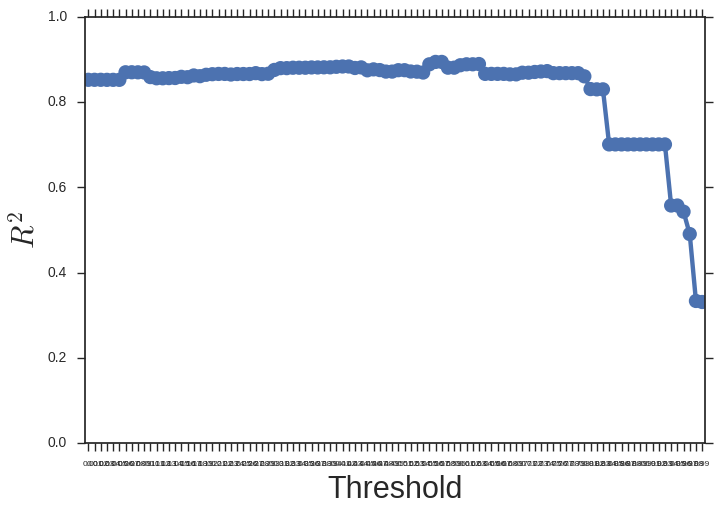

In [23]:
plt.figure()
plt.axis([0,1,0,1])
sns.pointplot(thresholds,r2_scores, scatter_kws={"s": 0.7})
plt.xlabel('Threshold', size=22)
plt.xticks(size=6)
plt.ylabel(r'$R^2$', size=22)
plt.yticks(size=10)
plt.show()

In [24]:
r2_max = r2_scores.max()
r2_max_idx = r2_scores.argmax()
thresh_max = thresholds[r2_max_idx]
optimal_scores_prod = otus_scores_prod[otus_scores_prod.values>thresh_max]
selected_otus = optimal_scores_prod.index

print('Number of selected OTUs: ' + str(len(selected_otus)))
print('R2 max = ' + str(r2_max))
print('Optimal threshold = ' + str(thresh_max))

Number of selected OTUs: 29
R2 max = 0.894025859274
Optimal threshold = 0.56


In [26]:
optimal_scores_prod.to_csv('HNAscores_prod_abun0.0075_Thr0.56.csv')

**-- SUMMARY --**

- We are able to predict the changes in the HNA-cloud up to high accuracy $R^2_{HNA(final)} = 0.959$, using our pipeline; This gives us a reduced set of OTU's (340 $\rightarrow$ 100). 
- This score is higher than using a 'standard' Lasso on all OTU's after initial filtering ($R^2_{HNA(abs)} = 0.768$). 
- Our pipeline in which we use absolute abundances gives added value, as only using the total cell counts gives us an $R^2_{HNA(Total.cells)} = 0.712$ 

**-- SUMMARY (Part 2) --**

- If we only include those OTU's which are significantly present in the productivity samples, the results change quite a bit. 
- $R^2_{final} = 0.894$, however the reduced set of OTU's becomes 97 $\rightarrow$ 29.
- This means that we can narrow down our subset of OTU's to 29 if we want to consider those OTU's which are significantly present in the productivity samples and can be related to the HNA-cloud. 